### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklvq import GLVQ
from chefboost import Chefboost as chef
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### UDFs

In [2]:
def count_plot(x, dataframe, ax=None):
    sns.countplot(x=x, data=dataframe, ax=ax)
    plt.box(False)
    return None

    
def pie_plot(df_col, fig_size, title):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(df_col.values, autopct='%1.2f%%', shadow=False, startangle=90)
    ax.axis('equal')
    plt.legend(labels=df_col.index, bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    return None


def stacked_vBar_plot(dataframe, value, index, column, xlabel, fig_size, scale='linear', with_percent=True):
    
    df_1 = dataframe.pivot_table(values=[value], index=[index], columns=[column], aggfunc=len, margins=True)
    df_1_percent = df_1.div(df_1.iloc[:,-1], axis=0).mul(100, axis=0).round(2)
    df_2_percent = df_1_percent.iloc[:, :-1].drop('All')
    
    columns = df_2_percent.columns.levels[1].tolist()
    columns.remove('All')
    
    ax = df_2_percent.plot.bar(stacked=True)
    ax.figure.set_size_inches(fig_size)
    ax.grid(False)
    plt.legend(labels=columns, bbox_to_anchor=(1.05, 1), title='NPS Type')
    plt.xlabel(xlabel)
    plt.ylabel('%GT Count of NPS_Type')
    
    if with_percent:
        # Add this loop to add the annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.2f}%'.format(height), (x + width/8, y + height/2))
    plt.box(False)
    plt.show()
    return None


def pdf_distribution_plots(df, features):
    nrow = int((len(features)/3) + len(features)%3)
    
    t0 = df.loc[df['class'] == '0']
    t1 = df.loc[df['class'] == '1']

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,10))

    for indx, feature in enumerate(features):
        ax = fig.add_subplot(nrow, 3, indx+1)
        sns.kdeplot(t0[feature], bw=0.5, label="0 - Benign", legend=True)
        sns.kdeplot(t1[feature], bw=0.5, label="1 - Malignant", legend=True)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='best')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace= 0.3, hspace=0.5)
    plt.show()
    return None

### Data Loading

In [3]:
wbcd_df = pd.read_csv("./data/breast-cancer-wisconsin-original.csv")

wbcd_df.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
wbcd_df.shape

(699, 11)

### Data Pre-Processing

##### Part I - Without Missing Values

In [5]:
# Pre-process the target column
wbcd_df['class'] = wbcd_df['class'].astype("category")
wbcd_df['class'] = np.where(wbcd_df['class']==2, '0', '1')
wbcd_df.drop(columns=['id'], inplace=True)

In [6]:
wbcd_df.dtypes

clump_thickness       int64
size_uniformity       int64
shape_uniformity      int64
marginal_adhesion     int64
epithelial_size       int64
bare_nucleoli        object
bland_chromatin       int64
normal_nucleoli       int64
mitoses               int64
class                object
dtype: object

In [7]:
wbcd_df.loc[wbcd_df['bare_nucleoli']=='?']

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
23,8,4,5,1,2,?,7,3,1,1
40,6,6,6,9,6,?,7,8,1,0
139,1,1,1,1,1,?,2,1,1,0
145,1,1,3,1,2,?,2,1,1,0
158,1,1,2,1,3,?,1,1,1,0
164,5,1,1,1,2,?,3,1,1,0
235,3,1,4,1,2,?,3,1,1,0
249,3,1,1,1,2,?,3,1,1,0
275,3,1,3,1,2,?,2,1,1,0
292,8,8,8,1,2,?,6,10,1,1


In [8]:
# Replace missing values indicated by ? with NaN
wbcd_wo_null_df = wbcd_df.copy()
wbcd_wo_null_df['bare_nucleoli'].replace('?', np.nan, inplace=True)

wbcd_wo_null_df.isna().sum()

clump_thickness       0
size_uniformity       0
shape_uniformity      0
marginal_adhesion     0
epithelial_size       0
bare_nucleoli        16
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                 0
dtype: int64

In [9]:
# Drop the 16 missing value records
wbcd_wo_null_df.dropna(inplace=True)
wbcd_wo_null_df['bare_nucleoli'] = wbcd_wo_null_df['bare_nucleoli'].astype('int64')

wbcd_wo_null_df.shape

(683, 10)

In [10]:
wbcd_wo_null_df.describe(include=np.number).applymap('{:,.2f}'.format)

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
count,683.00,683.00,683.00,683.00,683.00,683.00,683.00,683.00,683.00
mean,4.44,3.15,3.22,2.83,3.23,3.54,3.45,2.87,1.60
std,2.82,3.07,2.99,2.86,2.22,3.64,2.45,3.05,1.73
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,1.00
50%,4.00,1.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00
75%,6.00,5.00,5.00,4.00,4.00,6.00,5.00,4.00,1.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


In [11]:
wbcd_wo_null_df.describe(exclude=np.number)

,class
count,683
unique,2
top,0
freq,444


In [12]:
num_cols = wbcd_wo_null_df.select_dtypes(include=np.number).columns.to_list()
num_cols

['clump_thickness',
 'size_uniformity',
 'shape_uniformity',
 'marginal_adhesion',
 'epithelial_size',
 'bare_nucleoli',
 'bland_chromatin',
 'normal_nucleoli',
 'mitoses']

### Exploratory Data Analysis

##### Target frequency

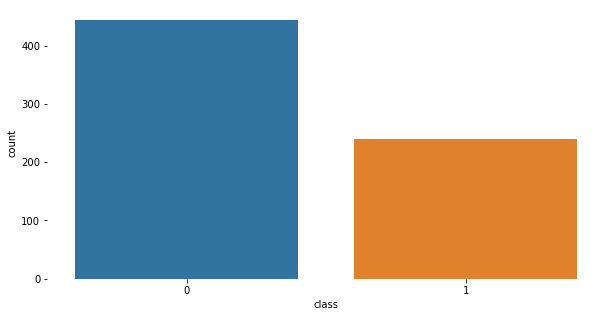

In [13]:
fig1, axes1 = plt.subplots(1, 1, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x='class', dataframe=wbcd_wo_null_df, ax=axes1)
plt.show()

##### Histograms

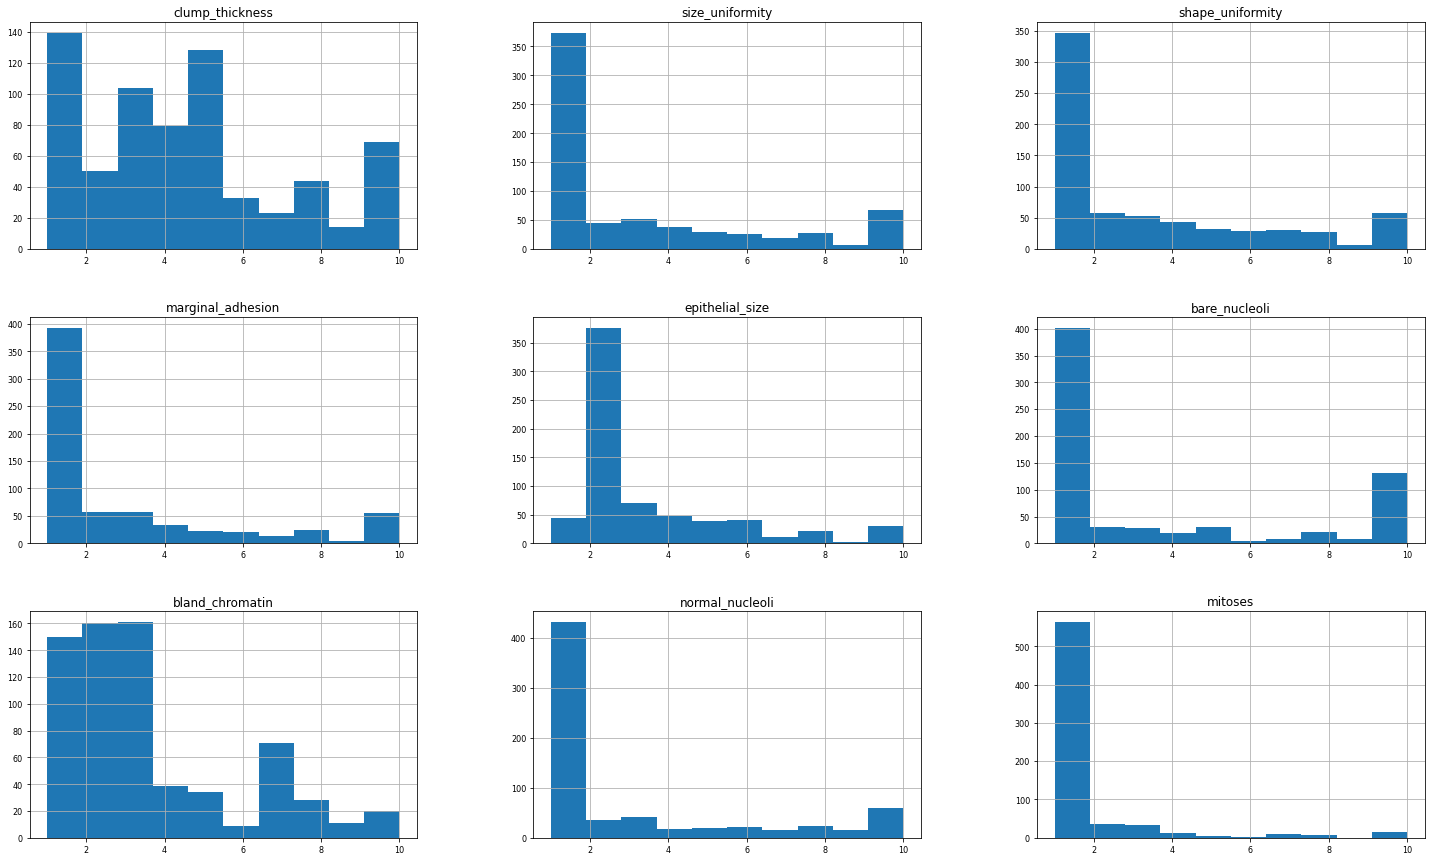

In [14]:
fig, ax = plt.subplots(figsize=(25, 15))
wbcd_wo_null_df[num_cols].hist(xlabelsize=8, ylabelsize=8, ax=ax, log=False)
plt.show()

##### PDF

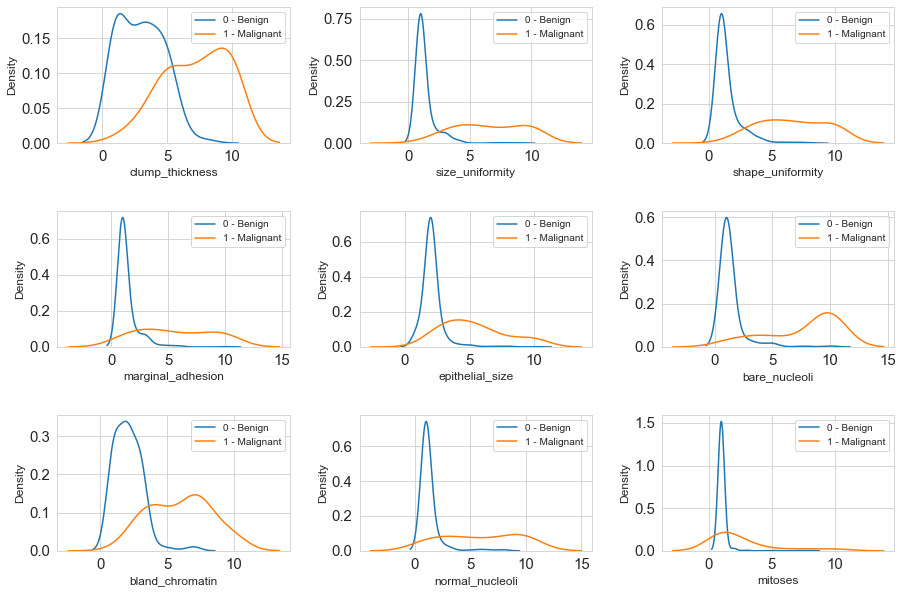

In [15]:
pdf_distribution_plots(df=wbcd_wo_null_df, features=num_cols)
plt.show()

##### Correlation

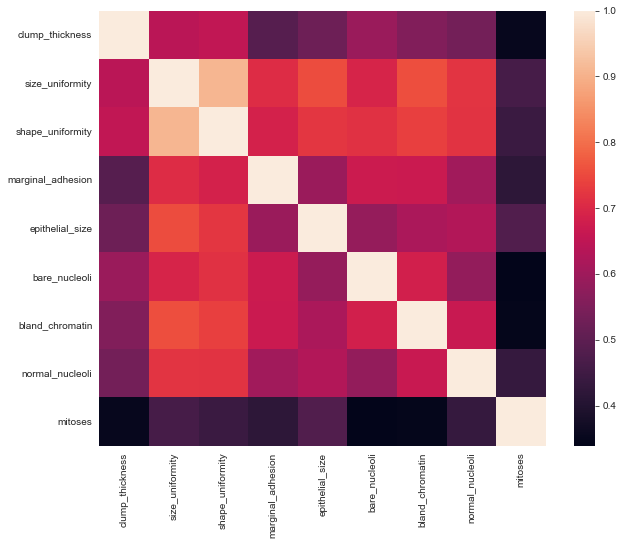

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
clump_thickness,1.000000,0.642481,0.653470,0.487829,0.523596,0.593091,0.553742,0.534066,0.350957
size_uniformity,0.642481,1.000000,0.907228,0.706977,0.753544,0.691709,0.755559,0.719346,0.460755
shape_uniformity,0.653470,0.907228,1.000000,0.685948,0.722462,0.713878,0.735344,0.717963,0.441258
marginal_adhesion,0.487829,0.706977,0.685948,1.000000,0.594548,0.670648,0.668567,0.603121,0.418898
epithelial_size,0.523596,0.753544,0.722462,0.594548,1.000000,0.585716,0.618128,0.628926,0.480583
bare_nucleoli,0.593091,0.691709,0.713878,0.670648,0.585716,1.000000,0.680615,0.584280,0.339210
bland_chromatin,0.553742,0.755559,0.735344,0.668567,0.618128,0.680615,1.000000,0.665602,0.346011
normal_nucleoli,0.534066,0.719346,0.717963,0.603121,0.628926,0.584280,0.665602,1.000000,0.433757
mitoses,0.350957,0.460755,0.441258,0.418898,0.480583,0.339210,0.346011,0.433757,1.000000


In [16]:
corr = wbcd_wo_null_df[num_cols].corr()

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

corr

### Model Development

In [17]:
# Create independent and dependent variables
X = wbcd_wo_null_df[num_cols]
y = wbcd_wo_null_df['class']

X.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3490, random_state=1295, shuffle=True, stratify=y)

y_train.value_counts()

0    289
1    155
Name: class, dtype: int64

In [19]:
# Standardize features
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Logistic Regression

In [20]:
lr_clf = LogisticRegression(solver='liblinear')

grid_values = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20)
}

grid_lr_clf = GridSearchCV(lr_clf, param_grid=grid_values, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)

grid_lr_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=10)

In [21]:
print('Grid best parameter (max. accuracy): ', grid_lr_clf.best_params_)
print('Grid best score (accuracy): ', grid_lr_clf.best_score_)
print('\nBest Estimator: ', grid_lr_clf.best_estimator_)

Grid best parameter (max. accuracy):  {'C': 4.281332398719396, 'penalty': 'l2'}
Grid best score (accuracy):  0.9819713993871299

Best Estimator:  LogisticRegression(C=4.281332398719396, solver='liblinear')


##### K Nearest Neighbors - kNN

In [22]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

grid_values = {
    'n_neighbors': [1, 2, 3, 5, 7, 9, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_knn_clf = GridSearchCV(knn_clf, param_grid=grid_values, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)

grid_knn_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 5, 7, 9, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

In [23]:
print('Grid best parameter (max. accuracy): ', grid_knn_clf.best_params_)
print('Grid best score (accuracy): ', grid_knn_clf.best_score_)
print('\nBest Estimator: ', grid_knn_clf.best_estimator_)

Grid best parameter (max. accuracy):  {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Grid best score (accuracy):  0.9797242083758938

Best Estimator:  KNeighborsClassifier(n_jobs=-1, n_neighbors=7, p=1)


##### Naive Bayes

In [24]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train_scaled, y_train)

GaussianNB()

##### Genaralized LVQ (GLVQ)

In [25]:
glvq_clf =  GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 20, "step_size": 0.1},
)

glvq_clf.fit(X_train_scaled, y_train)

GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'max_runs': 20, 'step_size': 0.1})

##### SVM

In [26]:
svm_clf = SVC()

grid_values = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_svm_clf = GridSearchCV(svm_clf, param_grid=grid_values, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)

grid_svm_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=10)

In [27]:
print('Grid best parameter (max. accuracy): ', grid_svm_clf.best_params_)
print('Grid best score (accuracy): ', grid_svm_clf.best_score_)
print('\nBest Estimator: ', grid_svm_clf.best_estimator_)

Grid best parameter (max. accuracy):  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Grid best score (accuracy):  0.9796986721144025

Best Estimator:  SVC(C=10, kernel='linear')


##### Decision Tree - C4.5 Algorithm

In [45]:
train_df, test_df = train_test_split(wbcd_wo_null_df, test_size=0.3490, random_state=1295)

train_df.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
419,2,3,1,1,5,1,1,1,1,0
116,8,3,3,1,2,2,3,2,1,0
154,1,1,1,1,2,1,1,1,1,0
163,1,1,1,2,1,3,1,1,7,0
329,10,4,6,4,5,10,7,1,1,1


In [46]:
config = {'algorithm': 'C4.5'}
dt_clf = chef.fit(train_df.copy(), config=config, target_label='class')

[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  4.530009508132935  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  98.87387387387388 % on  444  instances
Labels:  ['0' '1']
Confusion matrix:  [[285, 1], [4, 154]]
Precision:  99.6503 %, Recall:  98.6159 %, F1:  99.1304 %


### Model Evaluation

In [28]:
model = grid_svm_clf.best_estimator_
#model = glvq_clf

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [29]:
# Training set
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print(accuracy_score(y_train, y_train_pred))

[[285   4]
 [  4 151]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.97      0.97      0.97       155

    accuracy                           0.98       444
   macro avg       0.98      0.98      0.98       444
weighted avg       0.98      0.98      0.98       444

0.9819819819819819


In [30]:
# Test set
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(accuracy_score(y_test, y_test_pred))

[[151   4]
 [ 10  74]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       155
           1       0.95      0.88      0.91        84

    accuracy                           0.94       239
   macro avg       0.94      0.93      0.93       239
weighted avg       0.94      0.94      0.94       239

0.9414225941422594


##### Decision Tree - C4.5 - Model Evaluation

In [50]:
train_pred = []
actual = []

for index,item in train_df.iterrows():
    predicted_item = chef.predict(dt_clf, item)
    actual_item = item['class']
    train_pred.append(predicted_item)
    actual.append(actual_item)

print("Training Set Accuracy: {:.4f}".format(accuracy_score(train_pred, actual)))

Training Set Accuracy: 0.9887


In [51]:
test_pred = []
actual = []

for index,item in test_df.iterrows():
    predicted_item = chef.predict(dt_clf, item)
    actual_item = item['class']
    test_pred.append(predicted_item)
    actual.append(actual_item)

print("Test Set Accuracy: {:.4f}".format(accuracy_score(test_pred, actual)))

Test Set Accuracy: 0.9540


##### Part II - With Missing Values

In [52]:
# Replace missing values indicated by ? with 1
wbcd_with_null_df = wbcd_df.copy()
wbcd_with_null_df['bare_nucleoli'].replace('?', 1, inplace=True)
wbcd_with_null_df['bare_nucleoli'] = wbcd_with_null_df['bare_nucleoli'].astype('int64')

wbcd_with_null_df.isna().sum()

clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64

In [53]:
wbcd_with_null_df.describe(include=np.number).applymap('{:,.2f}'.format)

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
count,699.00,699.00,699.00,699.00,699.00,699.00,699.00,699.00,699.00
mean,4.42,3.13,3.21,2.81,3.22,3.49,3.44,2.87,1.59
std,2.82,3.05,2.97,2.86,2.21,3.62,2.44,3.05,1.72
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,1.00,1.00,1.00,2.00,1.00,2.00,1.00,1.00
50%,4.00,1.00,1.00,1.00,2.00,1.00,3.00,1.00,1.00
75%,6.00,5.00,5.00,4.00,4.00,5.00,5.00,4.00,1.00
max,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00


In [54]:
wbcd_with_null_df.describe(exclude=np.number)

,class
count,699
unique,2
top,0
freq,458


In [55]:
# Create independent and dependent variables
X = wbcd_with_null_df[num_cols]
y = wbcd_with_null_df['class']

X.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3490, random_state=1295, shuffle=True, stratify=y)

y_train.value_counts()

0    298
1    157
Name: class, dtype: int64

In [57]:
# Normalize features
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Logistic Regression

In [37]:
lr_clf = LogisticRegression(solver='liblinear')

grid_values = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20)
}

grid_lr_clf = GridSearchCV(lr_clf, param_grid=grid_values, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)

grid_lr_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=10)

In [38]:
print('Grid best parameter (max. accuracy): ', grid_lr_clf.best_params_)
print('Grid best score (accuracy): ', grid_lr_clf.best_score_)
print('\nBest Estimator: ', grid_lr_clf.best_estimator_)

Grid best parameter (max. accuracy):  {'C': 0.012742749857031334, 'penalty': 'l2'}
Grid best score (accuracy):  0.9714285714285713

Best Estimator:  LogisticRegression(C=0.012742749857031334, solver='liblinear')


##### K Nearest Neighbors - kNN

In [39]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

grid_values = {
    'n_neighbors': [1, 2, 3, 5, 7, 9, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_knn_clf = GridSearchCV(knn_clf, param_grid=grid_values, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)

grid_knn_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 5, 7, 9, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=10)

In [40]:
print('Grid best parameter (max. accuracy): ', grid_knn_clf.best_params_)
print('Grid best score (accuracy): ', grid_knn_clf.best_score_)
print('\nBest Estimator: ', grid_knn_clf.best_estimator_)

Grid best parameter (max. accuracy):  {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Grid best score (accuracy):  0.9692307692307693

Best Estimator:  KNeighborsClassifier(n_jobs=-1)


##### Naive Bayes

In [41]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train_scaled, y_train)

GaussianNB()

##### Genaralized LVQ (GLVQ)

In [42]:
glvq_clf =  GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 20, "step_size": 0.1},
)

glvq_clf.fit(X_train_scaled, y_train)

GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'max_runs': 20, 'step_size': 0.1})

#### SVM

In [43]:
svm_clf = SVC()

grid_values = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_svm_clf = GridSearchCV(svm_clf, param_grid=grid_values, scoring='accuracy', cv=5, n_jobs=-1, verbose=10)

grid_svm_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=10)

In [44]:
print('Grid best parameter (max. accuracy): ', grid_svm_clf.best_params_)
print('Grid best score (accuracy): ', grid_svm_clf.best_score_)
print('\nBest Estimator: ', grid_svm_clf.best_estimator_)

Grid best parameter (max. accuracy):  {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Grid best score (accuracy):  0.9714285714285715

Best Estimator:  SVC(C=0.01, kernel='linear')


##### Decision Tree - C4.5 Algorithm

In [58]:
train_df, test_df = train_test_split(wbcd_with_null_df, test_size=0.3490, random_state=1295)

train_df.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
490,1,1,1,1,2,1,1,1,1,0
224,10,5,5,6,3,10,7,9,2,1
212,1,1,1,1,2,1,3,1,1,0
181,1,1,1,1,2,1,1,1,1,0
390,1,1,1,2,2,1,2,1,1,0


In [59]:
config = {'algorithm': 'C4.5'}
dt_clf = chef.fit(train_df.copy(), config=config, target_label='class')

[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  5.289386749267578  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  98.24175824175825 % on  455  instances
Labels:  ['0' '1']
Confusion matrix:  [[293, 2], [6, 154]]
Precision:  99.322 %, Recall:  97.9933 %, F1:  98.6532 %


#### Model Evaluation

In [45]:
model = grid_svm_clf.best_estimator_
#model = glvq_clf

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [46]:
# Training set
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print(accuracy_score(y_train, y_train_pred))

[[290   8]
 [  5 152]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       298
           1       0.95      0.97      0.96       157

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455

0.9714285714285714


In [47]:
# Test set
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))  
print(accuracy_score(y_test, y_test_pred))

[[155   5]
 [  4  80]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       160
           1       0.94      0.95      0.95        84

    accuracy                           0.96       244
   macro avg       0.96      0.96      0.96       244
weighted avg       0.96      0.96      0.96       244

0.9631147540983607


##### Decision Tree - C4.5 - Model Evaluation

In [60]:
train_pred = []
actual = []

for index,item in train_df.iterrows():
    predicted_item = chef.predict(dt_clf, item)
    actual_item = item['class']
    train_pred.append(predicted_item)
    actual.append(actual_item)

print("Training Set Accuracy: {:.4f}".format(accuracy_score(train_pred, actual)))

Training Set Accuracy: 0.9824


In [61]:
test_pred = []
actual = []

for index,item in test_df.iterrows():
    predicted_item = chef.predict(dt_clf, item)
    actual_item = item['class']
    test_pred.append(predicted_item)
    actual.append(actual_item)

print("Test Set Accuracy: {:.4f}".format(accuracy_score(test_pred, actual)))

Test Set Accuracy: 0.9385
